## baseline lightning trainer notebook

Created on: Wednesday March 16th, 2022  
Created by: Jacob Alexander Rose  

In [2]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils
from hydra.experimental import compose, initialize, initialize_config_dir
import hydra
from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics

from imutils.ml.models.pl import classifier

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load test config

In [3]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              # "train.pl_trainer.gpus=4",
                                              "train.pl_trainer.accelerator=gpu",
                                              "model_cfg.backbone.name=resnext50_32x4d"],
                                              # "model_cfg.backbone.name=resnet_50"],
                                              # "model_cfg.backbone.name=xcit_large_24_p16_224"],
                                              # "model_cfg.backbone.name=resnetv2_101x1_bitm"],
                                             # "model_cfg.backbone.name=resnetv2_50"], 
                                 cfg = None)




In [4]:
OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()


hydra_dir = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17"


if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))

name 'HydraConfig' is not defined
/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17
run:
  dir: /media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17



## Instantiate experiment ingredients with config

In [5]:
from icecream import ic

# OmegaConf.register_new_resolver("int", int)

if cfg.train.deterministic:
    pl.seed_everything(cfg.train.random_seed)

if cfg.train.pl_trainer.fast_dev_run:
    hydra.utils.log.info(
        f"Debug mode <{cfg.train.pl_trainer.fast_dev_run}>. "
        f"Forcing debugger friendly configuration!"
    )
    cfg.train.pl_trainer.gpus = 0
    cfg.data.datamodule.num_workers = 0

try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    hydra_dir = os.getcwd()

hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
datamodule: pl.LightningDataModule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)
datamodule.setup()

self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 587840
    num_batches: 4593
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 251932
    num_batches: 985
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 822
    self.num_classes: 15501
    self.batch_size: 128


In [6]:
# logging.warning("1. Before model, before trainer")
hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(cfg.model, cfg=cfg, _recursive_=False)
model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                                      loss=cfg.model_cfg.loss)
# logging.warning("2. After model, before trainer")
# ic(torch.cuda.current_device())	
# ic(torch.cuda.get_device_name(0))
wandb_logger = configure_loggers(cfg=cfg, model=model)
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train)	
hydra.utils.log.info(f"Instantiating the Trainer")
pp(OmegaConf.to_container(cfg.train.pl_trainer))
trainer = configure_trainer(cfg,
                            callbacks=callbacks,
                            logger=wandb_logger)
# logging.warning("3. After model, after trainer, before fit")
# ic(torch.cuda.current_device())
num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]
hydra.utils.log.info("Starting training with {} classes across {} images in batches of {} images each.".format(
    num_classes,
    num_samples,
    batch_size))



Initializing weights of the model head.


ic| submodule: 'backbone'


Freezing up to 222 out of 223 layers in submodule=backbone
breaking: 222=222
Total frozen layers: 222, Total unfrozen layers: 160
input_size: (1, 3, 224, 224)


2022-03-25 09:57:44,167 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.RichProgressBar>
2022-03-25 09:57:44,173 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.LearningRateMonitor>
2022-03-25 09:57:44,176 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlyStopping>
2022-03-25 09:57:44,181 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
2022-03-25 09:57:44,189 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.WatchModelWithWandb>
2022-03-25 09:57:44,198 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.UploadCheckpointsToWandbAsArtifact>
2022-03-25 09:57:44,202 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pl_bolts.callbacks.ModuleDataMonito

{
    '_target_': 'pytorch_lightning.Trainer',
    'fast_dev_run': False,
    'accelerator': 'gpu',
    'devices': 1,
    'precision': 16,
    'enable_model_summary': True,
    'log_gpu_memory': True,
    'accumulate_grad_batches': 1,
    'strategy': {
        '_target_': 'pytorch_lightning.plugins.DDPPlugin',
        'find_unused_parameters': False
    }
}

Using 16bit native Automatic Mixed Precision (AMP)
/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:33: LightningDeprecationWarning: Setting `log_gpu_memory` with the trainer flag is deprecated in v1.5 and will be removed in v1.7. Please monitor GPU stats with the `DeviceStatsMonitor` callback directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
pp(OmegaConf.to_container(model.cfg, resolve=True))

{
    'core': {
        'name': 'herbarium2022__resnext50_32x4d',
        'version': '0.0.1',
        'tags': ['herbarium2022', 'kaggle']
    },
    'hp': {'preprocess_size': 256, 'resolution': 224, 'num_channels': 3},
    'seed': 42,
    'run_output_dir': 
'/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17',
    'checkpoint_dir': '/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022
-03-24/07-35-17/ckpts',
    'data': {
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022',
            'catalog_dir': '/media/data/jacob/GitHub/image-utils/imutils/big/data',
            'label_col': 'scientificName',
            'train_size': 0.7,
            'shuffle': True,
            'seed': 14,
            'batch_size': 128,
            'num_workers': 4,
            'pin_memory': True,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'preprocess': {
                    'train': {'resize': 256},
                    'val': {'resize': 256},
                    'test': {'resize': 256}
                },
                'batch_transform': {
                    'random_flips': False,
                    'train': {'random_resize_crop': 224},
                    'val': {'center_crop': 224},
                    'test': {'center_crop': 224}
                },
                'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
            },
            'remove_transforms': False,
            'image_reader': 'default',
            'datasets': {
                'herbarium2022': {
                    'train': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    },
                    'val': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'val',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': False,
                        'seed': 14
                    },
                    'test': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    }
                }
            }
        }
    },
    'model_cfg': {
        '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
        'backbone': {
            'model_repo': 'timm',
            'name': 'resnext50_32x4d',
            'pretrained': True,
            'freeze_backbone': True
        },
        'head': {
            'num_classes': 15501,
            'pool_size': 1,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': 512,
            'dropout_p': 0.3
        },
        'name': 'resnext50_32x4d',
        'loss': {'_target_': 'torch.nn.CrossEntropyLoss'},
        'resolution': 224,
        'num_channels': 3,
        'input_shape': [3, 224, 224]
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.001,
            'betas': [0.9, 0.999],

In [9]:
# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=14-val_loss=2.521-val_F1=0.443.ckpt"

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();


Initializing weights of the model head.
input_size: (1, 3, 224, 224)


In [10]:
pp(OmegaConf.to_container(model.cfg, resolve=True))

{
    'core': {
        'name': 'herbarium2022__resnext50_32x4d',
        'version': '0.0.1',
        'tags': ['herbarium2022', 'kaggle']
    },
    'hp': {'preprocess_size': 256, 'resolution': 224, 'num_channels': 3},
    'seed': 42,
    'run_output_dir': './hydra_experiments/2022-03-24/07-35-17',
    'checkpoint_dir': './hydra_experiments/2022-03-24/07-35-17/ckpts',
    'data': {
        'datamodule': {
            '_target_': 'imutils.ml.data.datamodule.Herbarium2022DataModule',
            'name': 'herbarium2022',
            'catalog_dir': '/media/data/jacob/GitHub/image-utils/imutils/big/data',
            'label_col': 'scientificName',
            'train_size': 0.7,
            'shuffle': True,
            'seed': 14,
            'batch_size': 64,
            'num_workers': 4,
            'pin_memory': True,
            'transform_cfg': {
                'preprocess_size': 256,
                'resolution': 224,
                'preprocess': {
                    'train': {'resize': 256},
                    'val': {'resize': 256},
                    'test': {'resize': 256}
                },
                'batch_transform': {
                    'random_flips': False,
                    'train': {'random_resize_crop': 224},
                    'val': {'center_crop': 224},
                    'test': {'center_crop': 224}
                },
                'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
            },
            'remove_transforms': False,
            'image_reader': 'default',
            'datasets': {
                'herbarium2022': {
                    'train': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    },
                    'val': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'val',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': False,
                        'seed': 14
                    },
                    'test': {
                        '_target_': 'imutils.ml.data.datamodule.Herbarium2022Dataset',
                        'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
                        'subset': 'train',
                        'label_col': 'scientificName',
                        'train_size': 0.7,
                        'shuffle': True,
                        'seed': 14
                    }
                }
            }
        }
    },
    'model_cfg': {
        '_target_': 'imutils.ml.models.pl.classifier.LitClassifier',
        'backbone': {
            'model_repo': 'timm',
            'name': 'resnext50_32x4d',
            'pretrained': False,
            'freeze_backbone': False
        },
        'head': {
            'num_classes': 15501,
            'pool_size': 1,
            'pool_type': 'avg',
            'head_type': 'linear',
            'hidden_size': 512,
            'dropout_p': 0.3
        },
        'name': 'resnext50_32x4d',
        'loss': {'_target_': 'torch.nn.CrossEntropyLoss'},
        'resolution': 224,
        'num_channels': 3,
        'input_shape': [3, 224, 224]
    },
    'optim': {
        'optimizer': {
            '_target_': 'torch.optim.Adam',
            'lr': 0.002,
            'betas': [0.9, 0.999],
            'eps': 1e-08,
            'weight_decay': 1e-05
        },
        'exclude_bn_b

In [13]:
# dir()

In [ ]:
results = {}

results['val'] = trainer.validate(model, datamodule=datamodule)

pp(results['val'])

initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please r

Output()

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/utilities
/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The 
batch size we found is 256. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.
  warning_cache.warn(

In [8]:
dir(model)

['CHECKPOINT_HYPER_PARAMS_KEY',
 'CHECKPOINT_HYPER_PARAMS_NAME',
 'CHECKPOINT_HYPER_PARAMS_TYPE',
 'T_destination',
 '_DeviceDtypeModuleMixin__update_properties',
 '_LightningModule__auto_choose_log_on_epoch',
 '_LightningModule__auto_choose_log_on_step',
 '_LightningModule__check_allowed',
 '_LightningModule__check_not_nested',
 '_LightningModule__to_tensor',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__jit_unused_properties__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_apply_batch_transfer_handler',
 '_auto_collect_arguments',
 '_automatic_optimization',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_cu

In [6]:
trainer.fit(model=model, datamodule=datamodule)

name 'HydraConfig' is not defined
self.transform_cfg:


{'preprocess': {'train': {'resize': 256}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}, 'random_flips': False}, 'normalize': [[0.485, 0.456, 0.406], 
[0.229, 0.224, 0.225]], 'preprocess_size': 256, 'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


ic| subset: 'train'
    num_samples: 587840
    num_batches: 4593
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'val'
    num_samples: 251932
    num_batches: 1969
    self.num_classes: 15501
    self.batch_size: 128
ic| subset: 'test'
    num_samples: 210407
    num_batches: 1644
    self.num_classes: 15501
    self.batch_size: 128


In [ ]:
from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))
# print(cfg['data']['datamodule']['transform_cfg'])

type(cfg.model_cfg.input_shape)
type(OmegaConf.to_container(cfg.model_cfg.input_shape, resolve=True)[0])

In [ ]:
# Instantiate model
# hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(model_cfg=cfg, _recursive_=False)


from imutils.ml.utils.model_utils import log_model_summary

model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# input_size = (1, 3,224,224)
# summary = log_model_summary(model=model,
#                             input_size=input_size,
#                             full_summary=True,
#                             working_dir=".",
#                             model_name=cfg.model_cfg.backbone.name,
#                             verbose=1)

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

# Instantiate the callbacks
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train) #OmegaConf.to_container(cfg.train, resolve=True))

model.freeze_up_to(layer=-1,
                  submodule="backbone")

# ([(n, p.requires_grad_(False)) for n, p in model.net.backbone.named_parameters()])
pp([(n, p.requires_grad) for n, p in model.net.backbone.named_parameters()])

In [11]:
# datamodule.test_dataset.df
# datamodule.train_dataset.df
import numpy as np
import torch

# ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=07-val_loss=3.338-val_F1=0.313.ckpt"

ckpt_path = "/media/data/jacob/GitHub/image-utils/imutils/ml/hydra_experiments/2022-03-24/07-35-17/hydra_experiments/2022-03-24/07-35-17/ckpts/epoch=10-val_loss=2.834-val_F1=0.384.ckpt"

# ckpt = torch.load(ckpt_path)
# print(ckpt.keys())

model = model.load_from_checkpoint(ckpt_path);
model.eval();
model.freeze();
# model.to("cpu")

# test_loader = datamodule.test_dataloader()
# batch = next(iter(test_loader))

# batch[1]#.cpu()

In [13]:
# batch[:2] = (b.cuda() for b in batch[:2])
# [b.cuda() for b in batch[:2]]

# batch[0] = batch[0].cuda()
# batch[1] = batch[1].cuda()
# x, y, metadata = batch
# x = x.to('cuda')
# y_logits = model(x)
# y_logits_top5 = torch.topk(torch.Tensor(y_logits.cpu()), k=5, dim=1)
# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()
# labels_k = le.decode_topk(y_logits_top5_idx)
# datamodule.train_dataset.label_encoder.classes_
# y_pred = torch.zeros_like(y_logits_top5.indices)
# topk_labels = np.empty((128,5), dtype="O")
# for k in range(5):
#     labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     topk_labels[:,k] = labels_k

#### Dev topk predictions

In [31]:
# import numpy as np
# topk_labels = [] #np.empty((128,5), dtype="string")

# topk = 5
# y_logits_top5_idx = y_logits_top5.indices.numpy()

# y = y_logits_top5_idx#.shape[1]

# if isinstance(y, np.ndarray):
#     if y.ndim == 2:
#         topk = y.shape[1]
#     else:
#         topk = 1
# if isinstance(y, list):
#     if isinstance(y[0], np.ndarray):
#         topk = y[0].shape[0]
#     elif isinstance(y[0], list):
#         topk = len(y[0])

# for k in range(topk):
#     # labels_k = datamodule.train_dataset.label_encoder.inverse_transform(y_logits_top5.indices[:,k])
#     labels_k = le.decode(y[:,k])
#     topk_labels.append(labels_k)

In [23]:
# topk_labels = np.vstack(topk_labels).T
# topk_labels.shape

# topk_labels[:2,:]
# true_labels = le.decode(y.numpy())
# topk_labels[0]

# from sklearn import preprocessing
# encoder = preprocessing.LabelEncoder()
# encoder.fit([0,4,-2,6])
# encoder.classes_

# class_list = getattr(encoder, "classes_", [])
# class2idx = {label: idx for idx, label in enumerate(class_list)}
# print(class2idx)

In [19]:
from imutils.ml.utils.label_utils import LabelEncoder

le = LabelEncoder.from_sklearn(datamodule.train_dataset.label_encoder)
le

In [ ]:
from typing import *
from imutils.ml.utils.model_utils import log_model_summary

log_model_summary(model, input_size=(2,3,224,224))

ckpt['epoch']
ckpt['global_step']
ckpt['pytorch-lightning_version']
ckpt['hparams_name']
ckpt['hyper_parameters']

In [50]:

datamodule.test_dataset.y_col
getattr(datamodule.test_dataset.df, "y", -1)
# df = datamodule.train_dataset.df
df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
above_25 = class_counts[class_counts.counts>=25]
above_10 = class_counts[class_counts.counts>=10]
above_5 = class_counts[class_counts.counts>=5]

below_5 = class_counts[class_counts.counts<5]
below_10 = class_counts[class_counts.counts<10]
below_25 = class_counts[class_counts.counts<25]

print("Min: ", min(class_counts.counts),"Max:", max(class_counts.counts))
pp(f"above_25: {above_25.shape[0]}, {above_25.shape[0] / num_classes:.4%}")
pp(f"above_10: {above_10.shape[0]}, {above_10.shape[0] / num_classes:.4%}")
pp(f"above_5: {above_5.shape[0]}, {above_5.shape[0] / num_classes:.4%}")

# pp(above_10.shape[0], above_10.shape[0] / num_classes)
# pp(above_5.shape[0], above_5.shape[0] / num_classes)

pp(f"below_5: {below_5.shape[0]}, {below_5.shape[0] / num_classes:.4%}")
pp(f"below_10: {below_10.shape[0]}, {below_10.shape[0] / num_classes:.4%}")
pp(f"below_25: {below_25.shape[0]}, {below_25.shape[0] / num_classes:.4%}")
# pp(below_10.shape[0], below_10.shape[0] / num_classes)
# pp(below_25.shape[0], below_25.shape[0] / num_classes)

In [57]:
def filter_catalog(catalog: pd.DataFrame,
                   column: str,
                   include=None,
                   exclude=None) -> pd.DataFrame:
    num_rows = catalog.shape[0]
    if isinstance(include, Sequence):
        pp(f"Including {len(include)}")
        catalog = catalog[catalog[column].apply(lambda x: x in include)]
    if isinstance(exclude, Sequence):
        pp(f"Excluding {len(exclude)}")
        
        catalog = catalog[catalog[column].apply(lambda x: x not in exclude)]

    pp(f"Input num_rows: {num_rows}")
    pp(f"Filtered num_rows: {catalog.shape[0]}, {catalog.shape[0]/num_rows:.3%}")
        
    return catalog

df = pd.concat([datamodule.train_dataset.df,
                datamodule.val_dataset.df])
                # datamodule.test_dataset.df])
class_counts = df.value_counts("y")
class_counts = class_counts.reset_index(drop=False).rename(columns={0:"counts"})
num_classes = class_counts.shape[0]
# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
above_20 = None
below_20 = class_counts[class_counts.counts<40].counts
below_20 = below_20.values.tolist()
above_20_catalog = filter_catalog(catalog=df,
                                  column="y",
                                  include=above_20,
                                  exclude=below_20)
above_20_catalog

Excluding 4471

Input num_rows: 839772

Filtered num_rows: 837841, 99.770%

,index,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,license,scientificName,family,genus,species,authors,collectionCode
0,800061,Trifolium fucatum,/media/data_cifs/projects/prj_fossils/data/raw...,14752,14756,2443,36,14756__047,147/56/14756__047.jpg,0,Trifolium fucatum Lindl.,Fabaceae,Trifolium,fucatum,Lindl.,NY
1,294940,Eragrostis urbaniana,/media/data_cifs/projects/prj_fossils/data/raw...,5484,5486,895,36,05486__011,054/86/05486__011.jpg,0,Eragrostis urbaniana Hitchc.,Poaceae,Eragrostis,urbaniana,Hitchc.,NY
2,546499,Osmorhiza purpurea,/media/data_cifs/projects/prj_fossils/data/raw...,10087,10091,1726,24,10091__046,100/91/10091__046.jpg,0,Osmorhiza purpurea (J.M.Coult. & Rose) Suksd.,Apiaceae,Osmorhiza,purpurea,(J.M.Coult. & Rose) Suksd.,ID
3,162934,Castilleja minor,/media/data_cifs/projects/prj_fossils/data/raw...,3088,3090,446,25,03090__061,030/90/03090__061.jpg,0,Castilleja minor (A.Gray) A.Gray,Orobanchaceae,Castilleja,minor,(A.Gray) A.Gray,IDS
4,206860,Corchorus hirsutus,/media/data_cifs/projects/prj_fossils/data/raw...,3894,3896,624,36,03896__020,038/96/03896__020.jpg,0,Corchorus hirsutus L.,Malvaceae,Corchorus,hirsutus,L.,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251927,667196,Quercus sinuata,/media/data_cifs/projects/prj_fossils/data/raw...,12301,12305,2023,13,12305__098,123/05/12305__098.jpg,0,Quercus sinuata Walter,Fagaceae,Quercus,sinuata,Walter,COLO
251928,735162,Sideroxylon lanuginosum,/media/data_cifs/projects/prj_fossils/data/raw...,13559,13563,2212,52,13563__050,135/63/13563__050.jpg,0,Sideroxylon lanuginosum Michx.,Sapotaceae,Sideroxylon,lanuginosum,Michx.,US
251929,127497,Campanula scabrella,/media/data_cifs/projects/prj_fossils/data/raw...,2464,2465,401,52,02465__029,024/65/02465__029.jpg,0,Campanula scabrella Engelm.,Campanulaceae,Campanula,scabrella,Engelm.,US
251930,359284,Gentiana clausa,/media/data_cifs/projects/prj_fossils/data/raw...,6666,6668,1021,21,06668__011,066/68/06668__011.jpg,0,Gentiana clausa Raf.,Gentianaceae,Gentiana,clausa,Raf.,GH


In [29]:
class_counts.describe()

# above_20 = class_counts[class_counts.counts>=20].counts
# above_20 = above_20.values.tolist()
# above_20 = None
below_20 = class_counts[class_counts.counts<40] # .counts

below_20.describe()

datamodule.val_dataset.df.value_counts("y")

dir(datamodule.train_dataset.df.groupby("y"))

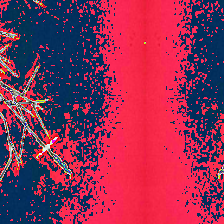

In [27]:

T.ToPILImage()(datamodule.train_dataset[1][0])

In [9]:
# from icecream import ic

# ic(9, 4)

# 16081624 / 587840

# 16081624 / 24

# 18454*24/3/60

# pp([(n, p.requires_grad) for n, p in model.net.head.named_parameters()])

# model.net.head.state_dict().keys()

# model.net["backbone"].state_dict().keys()

# import pytorch_lightning as pl

# pl.__version__

# 4593*8*2*64*2

# 2264842//128

# 9048210 / 32

# 13122*48

# datamodule.setup("fit")



train --> (num_samples: 587,840), (num_batches: 9,185)
train --> (num_samples: 587,840), (num_batches: 9,185)
val --> (num_samples: 251,932), (num_batches: 3,937)
val --> (num_samples: 251,932), (num_batches: 3,937)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [19]:
# val_loader = datamodule.val_dataloader()

# batch = next(iter(val_loader))

# len(batch)

# import torch
# from torch import nn
# # Single-label categorical
# x = torch.randn(10, 5)
# y = torch.randint(5, (10,))
# loss = nn.CrossEntropyLoss()(x, y)


# print(x.shape, y.shape, loss.shape)
# print(x.dtype, y.dtype, loss.dtype)

# # model

# num_samples = len(datamodule.train_dataset)
# num_batches = len(datamodule.train_dataloader())

# ic(num_samples, num_batches, num_samples/ num_batches)

# import numpy as np

# print(f"{2264842/2:,}")

# print(f"{2264842/3:,}")

# ic(num_samples * np.arange(5))

In [37]:
x, y = batch[:2]
print(x.shape, y.shape)
print(x.dtype, y.dtype)
# model

x, y = batch[:2]
logits = model(x)

loss = nn.CrossEntropyLoss()(logits, y)
print(logits.shape, logits.dtype)
print(loss.shape, loss.dtype)

from icecream import ic

a = {0, 8}
ic(a)
# datamodule.transform_cfg
# datamodule.setup_transforms(datamodule.transform_cfg)

In [46]:
# datamodule.setup_transforms(datamodule.transform_cfg)
# from imutils.ml.data.datamodule import get_default_transforms
# a = get_default_transforms(mode="train", config=datamodule.transform_cfg)

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


Compose(
    Preprocess(
  (resize_func): Resize(size=512, interpolation=bilinear)
)
    BatchTransform(
  (transforms): Sequential(
    (0): RandomPerspective(p=0.5)
    (1): RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    (2): RandomHorizontalFlip(p=0.5)
    (3): RandomVerticalFlip(p=0.5)
    (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
)
)

In [12]:
import wandb
def configure_loggers(cfg):

    wandb_logger = None
    if "wandb" in cfg.logging:
        hydra.utils.log.info(f"Instantiating <WandbLogger>")
        wandb_config = cfg.logging.wandb
        wandb_logger = pl.loggers.WandbLogger(
            name=wandb_config
            .get("name", 
                           (cfg.data.datamodule.get("name") + "__" + cfg.model_cfg.name)),
            project=wandb_config.project,
            entity=wandb_config.entity,
            tags=cfg.core.tags,
            log_model=True,
        )
        hydra.utils.log.info(f"W&B is now watching <{wandb_config.watch.log}>!")
        wandb_logger.watch(
            model, log=wandb_config.watch.log, log_freq=wandb_config.watch.log_freq
        )


        hydra.utils.log.info(f"Instantiating the Trainer")
    return wandb_logger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [22]:
# wandb_logger = configure_loggers(cfg=cfg, model=model)
# print(wandb_logger)

# # The Lightning core, the Trainer
# trainer = pl.Trainer(
#     default_root_dir=cfg.hydra.run.dir,
#     logger=wandb_logger,
#     callbacks=callbacks,
#     deterministic=cfg.train.deterministic,
#     val_check_interval=cfg.logging.val_check_interval,
#     log_every_n_steps=10,
#     #auto_select_gpus=True,
#     # benchmark=True,
#     # accelerator=None,  # 'dp', "ddp" if args.gpus > 1 else None,
#     #plugins=[DDPPlugin(find_unused_parameters=True)],
#     **cfg.train.pl_trainer,
# )
# # num_samples = len(datamodule.train_dataset)
# num_classes = cfg.model_cfg.head.num_classes
# batch_size = datamodule.batch_size #["train"]
# hydra.utils.log.info("Starting training with {} classes and batches of {} images".format(
#     num_classes,
#     batch_size))
# # pp(OmegaConf.to_container(cfg.train.callbacks, resolve=True))
# trainer.fit(model=model, datamodule=datamodule)
# #%debug
# hydra.utils.log.info(f"Starting testing!")
# trainer.test(model=model, datamodule=datamodule)
# shutil.copytree(".hydra", Path(wandb_logger.experiment.dir) / "hydra")

## Measure time and function wrapping

In [22]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        from time import time
        start = time()
        result = func(*args, **kwargs)
        total_time = time() - start
        print(f'Elapsed time is {total_time} ms')
        
        if isinstance(result, int):
            print(f"{result}/{total_time} = {result/(total_time):.3f} samples/sec")
        return result
    return wrapper

In [13]:
# from tqdm import tqdm

@measure_time
def loop_through_dataloader(dataloader, num_batches):
    data_iter = iter(dataloader)
    for i, batch in tqdm(enumerate(data_iter), total=num_batches):
        if i > num_batches-1:
            break
    num_samples = i*len(batch[0])
    return num_samples



# train_iter = iter(datamodule.train_dataloader())
# datamodule.setup()
# dataloader = datamodule.train_dataloader()
# num_batches = 40
# loop_through_dataloader(dataloader, num_batches)
# bb = next(iter(dataloader))
# pp(datamodule.cfg)
# pp(OmegaConf.to_container(datamodule.cfg))

In [11]:
type(datamodule.cfg)

omegaconf.dictconfig.DictConfig

In [4]:

# default_cfg = DictConfig(dict(
#     catalog_dir=None,
#     label_col="scientificName",
#     train_size=0.7,
#     shuffle=True,
#     seed=14,
#     batch_size = 128,
#     num_workers = None,
#     pin_memory=True,
#     transform_cfg=None,
#     remove_transforms=False,
# ))

# from rich import print as pp

# pp(OmegaConf.to_yaml(default_cfg))

### Mock config yaml

In [ ]:
# CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      num_workers=4,
#                                      # image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()

# subset = "train"
# dataset = datamodule.get_dataset(subset=subset)

# dataset.num_classes

# trainer.fit(model, datamodule)

## End

In [ ]:
# from torchvision import transforms as T
# import argparse
# from rich import print as pp

# args = argparse.Namespace(
#     preprocess={
#         "train":{
#             "resize":512
#         },
#         "val":{
#             "resize":256
#         },
#     },
#     batch_transform={
#         "train":{
#             "random_resize_crop":224
#         },
#         "val":{
#             "center_crop":224
#         },
#     normalize=(
#        [0.485, 0.456, 0.406],
#        [0.229, 0.224, 0.225]
#     )
#     }
# )
# pp(args)

# kornia_transform = nn.Sequential(
#     K.RandomHorizontalFlip(),
#     K.RandomVerticalFlip(),
#     K.RandomMotionBlur(3, 35., 0.5),
#     K.RandomRotation(degrees=45.0),
#     K.Normalize(mean=mean_std,std=mean_std)
# )

# import numpy as np
# from torch import nn
# import torch
# from albumentations.augmentations import transforms as AT

# to_tensor = T.ToTensor()

# class Preprocess(nn.Module):

#     def __init__(self, mode="train", resize=None):
#         super().__init__()
#         self.mode = mode
#         self.resize = resize        
#         self.resize_func = T.Resize(self.resize)
    
#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x) -> torch.Tensor:
#         # x_tmp: np.ndarray = np.array(x)  # HxWxC
#         # x_out: Tensor = to_tensor(x_tmp, keepdim=True)  # CxHxW
#         if self.resize:
#             x = self.resize_func(x)

#         return x #_out.float()# / 255.0




# class BatchTransforms(nn.Module):
#     """Module to perform data augmentation using Kornia on torch tensors."""

#     def __init__(self,
#                  mode: str="train",
#                  random_resize_crop=None,
#                  center_crop=None,
#                  apply_color_jitter: bool = False,
#                  normalize = (
#                      [0,0,0],
#                      [1,1,1]
#                  )
#                 ) -> None:
#         super().__init__()
#         self.mode = mode
#         self.random_resize_crop = random_resize_crop
#         self.center_crop = center_crop
#         self._apply_color_jitter = apply_color_jitter
#         self.normalize = normalize
        
#         self.build_transforms(mode=mode)

        
#     def add_train_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         # if mode == "train":
#         transforms.append(T.RandomPerspective())
#         if type(self.random_resize_crop) == int:
#             transforms.append(T.RandomResizedCrop(self.random_resize_crop))
#         transforms.extend([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip()
#         ])
#         return transforms

#     def add_test_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         if type(self.center_crop) == int:
#             transforms.append(T.CenterCrop(self.center_crop))
#         return transforms


#     def build_transforms(self,
#                          mode: str = "train"):
#         transforms = []
#         if mode == "train":
#             transforms = self.add_train_transforms(transforms=transforms)
#         elif mode in ["val", "test"]:
#             transforms = self.add_test_transforms(transforms=transforms)

#         transforms.extend([
# 			# T.ToTensor(),
# 			T.Normalize(*self.normalize)
#         ])

#         self.transforms = nn.Sequential(*transforms)
#         self.jitter = AT.ColorJitter(brightness=0.2,
#                                      contrast=0.2,
#                                      saturation=0.2,
#                                      hue=0.2,
#                                      always_apply=False,
#                                      p=0.5)

#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x_out = self.transforms(x)  # BxCxHxW
#         if self._apply_color_jitter:
#             x_out = self.jitter(x_out)
#         return x_out







# for subset in ["train","val", "test"]:
#     data = Herbarium2022Dataset(subset=subset,
#                                 label_col="scientificName",
#                                 train_size=0.7,
#                                 shuffle=(subset != "test"),
#                                 seed=14,
#                                 transform=None)

#########################################

CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"
SHARD_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/webdataset"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      batch_size=64,
#                                      num_workers=4,
#                                      image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()


# train_dataloader = datamodule.train_dataloader()
# train_batch = next(iter(train_dataloader))
# datamodule.train_dataset.encoder.inverse_transform(train_batch[1])

# checkpoint_callback = [c for c in callbacks if isinstance(c, pl.callbacks.ModelCheckpoint)][0]
# logging.info(f"checkpoint_callback.best_model_path: {str(checkpoint_callback.best_model_path)}")
# config.system.tasks[f"task_{task_id}"].ckpt_path = checkpoint_callback.best_model_path
# checkpoint_callback.best_model_score = checkpoint_callback.best_model_score or 0.0
# logging.info(f"checkpoint_callback.best_model_score: {checkpoint_callback.best_model_score:.3f}")
# logging.info(f"[Initiating TESTING on task_{task_id}]")


# test_results = run_multitask_test(trainer=trainer,
#                               model=model,
#                               datamodule=datamodule,
#                               config=config,
#                               tasks="all")#,